# Machine Learning Project -- Feed-Forward vs LSTM vs Transformers

_Tristan LEDUC_ \
_Paul LEGOUT_

# Weather forecasting

In [1672]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import models, layers, datasets
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

import random
import pprint

In [27]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

# Load data

Hourly predictions

In [28]:
data = pd.read_csv(csv_path)

In [29]:
data.shape

(420551, 15)

## Preprocessing

In [30]:
data.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
data.tail(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420550,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


In [7]:
data.describe().transpose().drop(["count"], axis=1)

,mean,std,min,25%,50%,75%,max
p (mbar),989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


### Manage errors

Obviously, wind speed and max wind speed should be >=0

In [31]:
wv = data["wv (m/s)"]
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = data["max. wv (m/s)"]
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0
data["wv (m/s)"].min()

/var/folders/h_/r3j4_s3d5973t55ttlf7h3vh0000gn/T/ipykernel_6882/3224106521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wv[bad_wv] = 0.0
/var/folders/h_/r3j4_s3d5973t55ttlf7h3vh0000gn/T/ipykernel_6882/3224106521.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_wv[bad_max_wv] = 0.0


0.0

### Convert Wind direction (radian) to a vector (cos ($\theta$), sin($\theta$))

Indeed, the wind direction is given in degrees and angles do not make a good model inputs. 360° and 0° should be close to each others, however the model will not get that. Moreover, wind speed and wind direction are decoupled, but the wind direction should not matter if the wind is not blowing. Thus, we will convert the wind direction / velocity into a vector wind / max wind with respect to x, and with respect to y

In [32]:
wv = data.pop("wv (m/s)")
max_wv = data.pop("max. wv (m/s)")

# Convert to radians
wd_rad = data.pop("wd (deg)") * np.pi / 180

# Calculate the wind x and y components
data["wx"] = wv * np.cos(wd_rad)
data["wy"] = wv * np.sin(wd_rad)

# Same for max wind speed
data["max wx"] = max_wv * np.cos(wd_rad)
data["max wy"] = max_wv * np.sin(wd_rad)

### Manage date time

##### Convert to seconds

In [33]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp = date_time.map(pd.Timestamp.timestamp)

##### Display periodicity

In [34]:
day = 24 * 60 * 60
year = (365.2425) * day

data["Day sin"] = np.sin(timestamp / (2 * np.pi / day))
data["Day cos"] = np.cos(timestamp / (2 * np.pi / day))

data["Year sin"] = np.sin(timestamp / (2 * np.pi / year))
data["Year cos"] = np.cos(timestamp / (2 * np.pi / year))

In [12]:
data.head(5)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wx,wy,max wx,max wy,Day sin,Day cos,Year sin,Year cos
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,-0.911955,0.478787,-1.549439,0.813474,0.701851,-0.712323,-0.716728,-0.697352
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,-0.518797,0.499249,-1.080827,1.040103,-0.502528,0.864561,-0.173856,0.984771
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,-0.187962,0.027756,-0.623242,0.092032,0.271592,-0.962412,0.912186,-0.409776
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,-0.323359,-0.105066,-0.475528,-0.154508,-0.025525,0.999674,-0.851669,-0.524080
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,-0.264351,-0.180328,-0.520442,-0.355021,-0.224028,-0.974583,0.045302,0.998973


### Split data

70% training, 20% validation and 10% testing

In [35]:
# No shuffle!
n = len(data)

train_data = data[: int(n * 0.7)]
validation_data = data[int(n * 0.7): int(n * 0.9)]
test_data = data[int(n * 0.9):]

num_features = data.shape[1]

### Normalization

In [36]:
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
validation_data = (validation_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

### Data windowing

Take n previous days et predict the next m days

In [869]:
class WindowGenerator():
	def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
		# Store the raw data
		self.train_df = train_df
		self.val_df = val_df
		self.test_df = test_df

		# Work out the label column indices
		self.label_columns = label_columns
		if label_columns is not None:
			self.label_columns_indices = {
				name: i 
				for i, name in enumerate(label_columns)
				}

		self.column_indices = {
			name: i 
			for i, name in enumerate(train_df.columns)
		}

		# Work out the window parameters
		self.input_width = input_width
		self.label_width = label_width
		self.shift = shift

		self.total_window_size = input_width + shift

		self.input_slice = slice(0, input_width)
		self.input_indices = np.arange(self.total_window_size)[self.input_slice]

		self.label_start = self.total_window_size - self.label_width
		self.label_slice = slice(self.label_start, None)
		self.label_indices = np.arange(self.total_window_size)[self.label_slice]

	

	def __repr__(self):
		return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

	def split_window(self, features):
		inputs = features[:, self.input_slice, :]
		labels = features[:, self.label_slice, :]

		if self.label_columns is not None:
			labels = tf.stack(
				[labels[:, :, self.column_indices[name]] for name in self.label_columns],
				axis=-1
			)

		# Slicing doesn't preserve static shape information, so set the shapes manually. This way, the "tf.data.Datasets" are easier to inspect
		inputs.set_shape([None, self.input_width, None])
		labels.set_shape([None, self.label_width, None])

		return inputs, labels


	def plot(self, model=None, y_label="T (degC)", x_label="Time (h)", max_subplots=3):
		inputs, labels = self.example
		plt.figure(figsize=(12, 8 * max_subplots / 3))
		plot_col_index = self.column_indices[y_label]
		max_n = min(max_subplots, len(inputs))

		for n in range(max_n):
			plt.subplot(max_n, 1, n+1)
			plt.ylabel(f'{y_label} [normed]')
			plt.plot(self.input_indices, inputs[n, :, plot_col_index],
						label='Inputs', marker='.', zorder=-10)

			if self.label_columns:
				label_col_index = self.label_columns_indices.get(y_label, None)
			else:
				label_col_index = plot_col_index

			if label_col_index is None:
				continue
			
			plt.scatter(self.label_indices, labels[n, :, label_col_index],
						edgecolors='k', label='Labels', c='#2ca02c', s=64)
			if model is not None:
				predictions = model(inputs)

				plt.scatter(self.label_indices, predictions[n, :, 0],
							marker='X', edgecolors='k', label='Predictions',
							c='#ff7f0e', s=64)

			if n == 0:
				plt.legend()

		plt.xlabel(x_label)



	def plot_test(self, model, y_label="T (degC)", x_label="Time (h)", batch_size=32):
		plt.figure(figsize=(12, 4))
		size = 20
		iter_data = iter(self.make_dataset(self.test_df, shuffle=False))

		i_max = len(self.test_df) // batch_size
		iter_random = random.randint(0, i_max - 1)

		for _ in range(iter_random):
			next(iter_data)

		inputs, labels = next(iter_data)
		
		plot_col_index = self.column_indices[y_label]
		label_col_index = 0
		if self.label_columns:
				label_col_index = self.label_columns_indices.get(y_label, None)
		else:
			label_col_index = plot_col_index


		x = [i for i in range(size + 4)]
		
		predictions = model(inputs)

		plt.plot(x, [labels[i, :, label_col_index] for i in range(len(x))], marker='.', zorder=-10, label='Inputs')

		plt.scatter(x[4:], [labels[i + 4, :, label_col_index] for i in range(size)], edgecolors='k', label='Labels', c='#2ca02c', s=64)
		plt.scatter(x[4:], [predictions[i + 4, :, label_col_index] for i in range(size)], marker='X', edgecolors='k', label='Predictions',
							c='#ff7f0e', s=64)
		

		plt.xlabel(x_label)
		plt.ylabel(y_label)
		plt.legend()


	def make_dataset(self, data, shuffle=True):
		data = np.array(data, dtype=np.float32)
		ds = tf.keras.utils.timeseries_dataset_from_array(
			data=data,
			targets=None,
			sequence_length=self.total_window_size,
			sequence_stride=1,
			shuffle=shuffle,
			batch_size=32
		)
		ds = ds.map(self.split_window)
		return ds


	def display_shapes(self, num=1):
		for example_inputs, example_labels in self.train.take(num):
			print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
			print(f"Labels shape (batch, time, features): {example_labels.shape}")

	def shapes(self):
		for example_inputs, example_labels in self.train.take(1):
			return example_inputs.shape, example_labels.shape


	@property
	def train(self):
		return self.make_dataset(self.train_df)

	@property
	def val(self):
		return self.make_dataset(self.val_df)

	@property
	def test(self):
		return self.make_dataset(self.test_df)

	@property
	def example(self):
		"""Get and cache an example batch of inputs, labels for plotting"""
		result = getattr(self, '_example', None)
		if (result is None):
			# No example batch was found, so get one from the .train dataset
			result = next(iter(self.train))
			# And cache it for the next time
			self._example = result
		return result


### Test windowing

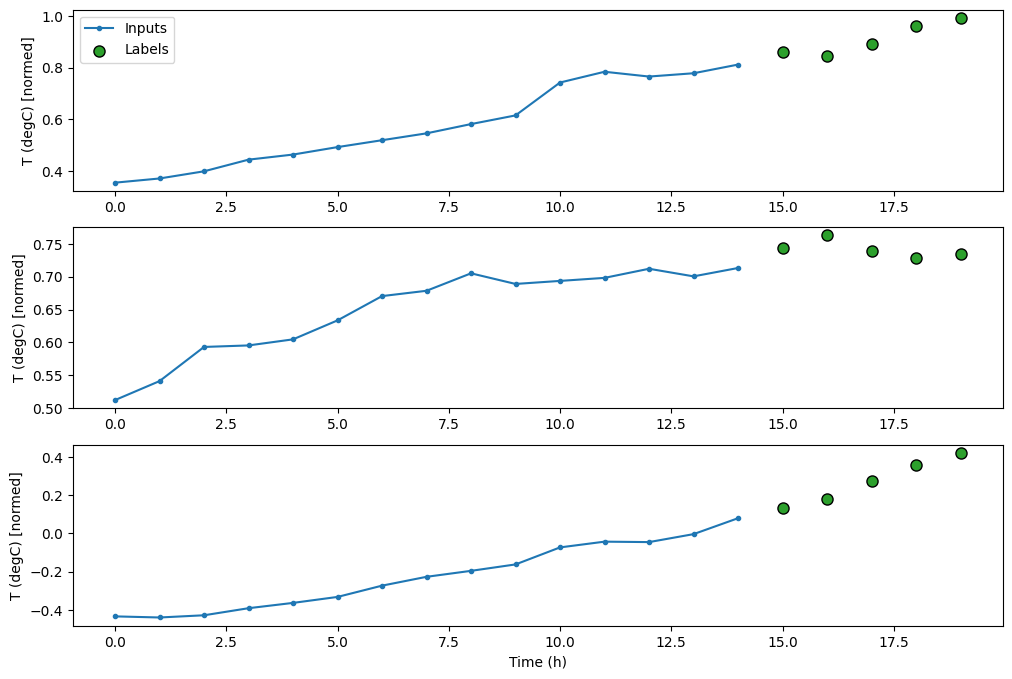

In [230]:
# Takes 15 previous hours
IN_STEP = 15

# To predict the 5 next
OUT_STEP = 5

window = WindowGenerator(input_width=IN_STEP, label_width=OUT_STEP, shift=OUT_STEP, train_df=train_data, val_df=validation_data, test_df=test_data, label_columns=["T (degC)"])

window.plot()

In [17]:
window.display_shapes()

Inputs shape (batch, time, features): (32, 15, 19)
Labels shape (batch, time, features): (32, 5, 1)


In [18]:
print(window.shapes())

(TensorShape([32, 15, 19]), TensorShape([32, 5, 1]))


# General functions

In [1399]:
def compile_and_fit(model: models.Sequential, window: WindowGenerator, max_epochs=1000, batch_size=None, patience=5, learning_rate=0.001):
	early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, mode="min")

	model.compile(
		loss=tf.keras.losses.MeanSquaredError(),
		optimizer=tf.keras.optimizers.Adam(learning_rate),
		metrics=[tf.keras.metrics.MeanAbsoluteError()]
	)

	return model.fit(
		window.train,
		epochs=max_epochs,
		validation_data=window.val,
		batch_size=batch_size,
		callbacks=early_stopping
	)

In [40]:
def evaluate_model(model: models.Sequential, window: WindowGenerator):
	total_loss = model.evaluate(window.test)
	print(f"Total loss = {total_loss}")

	return total_loss

In [41]:
def plot_res(history, start: int, validation_loss=True):
	plt.plot(history.history["loss"][start:], label="Training loss")
	if validation_loss:
		plt.plot(history.history["val_loss"][start:], label="Validation loss")
	plt.title("Loss over epochs")
	plt.ylabel("Loss value")
	plt.xlabel("Epochs")
	plt.legend()

In [718]:
def save_model(model: models.Sequential, name: str):
	model.save(f"../../resources/weather_forecasting/{name}.h5")

In [43]:
def load_model(name: str):
	return models.load_model(f"../../resources/weather_forecasting/{name}.h5")

In [1625]:
performance = {}
validation_perf = {}

performance_multi = {}
validation_perf_multi = {}

# Single Output

In [1302]:
in_dim = 5
out_dim = 1

# Given a 5 hours input, predict the next hour (Temperature in °C)
window = WindowGenerator(in_dim, out_dim, out_dim, train_data, validation_data, test_data, label_columns=["T (degC)"])

input_shapes = window.shapes()[0]
label_shapes = window.shapes()[1]

## Feed-forward network

In [702]:
def create_feed_forward(output_dim=1):
	model = models.Sequential()
	# Shapes (time, features) => (time*features)
	model.add(layers.Flatten())

	model.add(layers.Dense(32, activation="relu"))
	model.add(layers.Dense(32, activation="relu"))

	model.add(layers.Dense(output_dim))

	# Add back the time dimension: Shape (outputs) => (1, outputs)
	model.add(layers.Reshape([output_dim, -1]))

	return model

In [ ]:
ff_model = create_feed_forward()

In [587]:
ff_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 95)                0         
                                                                 
 dense_32 (Dense)            (None, 32)                3072      
                                                                 
 dense_33 (Dense)            (None, 32)                1056      
                                                                 
 dense_34 (Dense)            (None, 1)                 33        
                                                                 
 reshape_7 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 4,161
Trainable params: 4,161
Non-trainable params: 0
_________________________________________________________________


In [467]:
ff_history = compile_and_fit(ff_model, window, patience=5)
save_model(ff_model, "ff_model")

Epoch 1/1000
   1/9200 [..............................] - ETA: 1:01:30 - loss: 1.5245 - mean_absolute_error: 1.0189

2022-11-19 17:42:48.494394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9200/9200 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0362

2022-11-19 17:43:58.298349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9200/9200 [==============================] - 80s 9ms/step - loss: 0.0041 - mean_absolute_error: 0.0362 - val_loss: 8.1877e-04 - val_mean_absolute_error: 0.0201
Epoch 2/1000
9200/9200 [==============================] - 77s 8ms/step - loss: 9.0499e-04 - mean_absolute_error: 0.0214 - val_loss: 6.5851e-04 - val_mean_absolute_error: 0.0175
Epoch 3/1000
9200/9200 [==============================] - 71s 8ms/step - loss: 7.9915e-04 - mean_absolute_error: 0.0199 - val_loss: 6.6285e-04 - val_mean_absolute_error: 0.0174
Epoch 4/1000
9200/9200 [==============================] - 73s 8ms/step - loss: 7.4010e-04 - mean_absolute_error: 0.0190 - val_loss: 6.0176e-04 - val_mean_absolute_error: 0.0166
Epoch 5/1000
9200/9200 [==============================] - 66s 7ms/step - loss: 7.1676e-04 - mean_absolute_error: 0.0187 - val_loss: 5.9398e-04 - val_mean_absolute_error: 0.0166
Epoch 6/1000
9200/9200 [==============================] - 65s 7ms/step - loss: 6.9201e-04 - mean_absolute_error: 0.0183 - val_loss: 

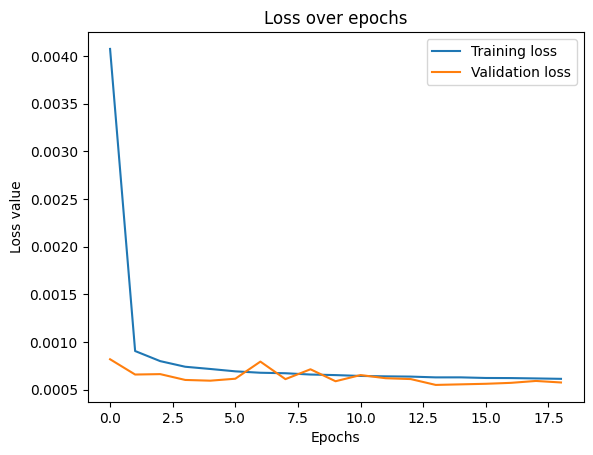

In [468]:
plot_res(ff_history, 0)

In [1626]:
validation_perf["ff"] = ff_model.evaluate(window.val)

2629/2629 [==============================] - 14s 5ms/step - loss: 5.7519e-04 - mean_absolute_error: 0.0162


In [1627]:
performance["ff"] = evaluate_model(ff_model, window)

1315/1315 [==============================] - 7s 5ms/step - loss: 6.1459e-04 - mean_absolute_error: 0.0169
Total loss = [0.000614590710029006, 0.01689978502690792]


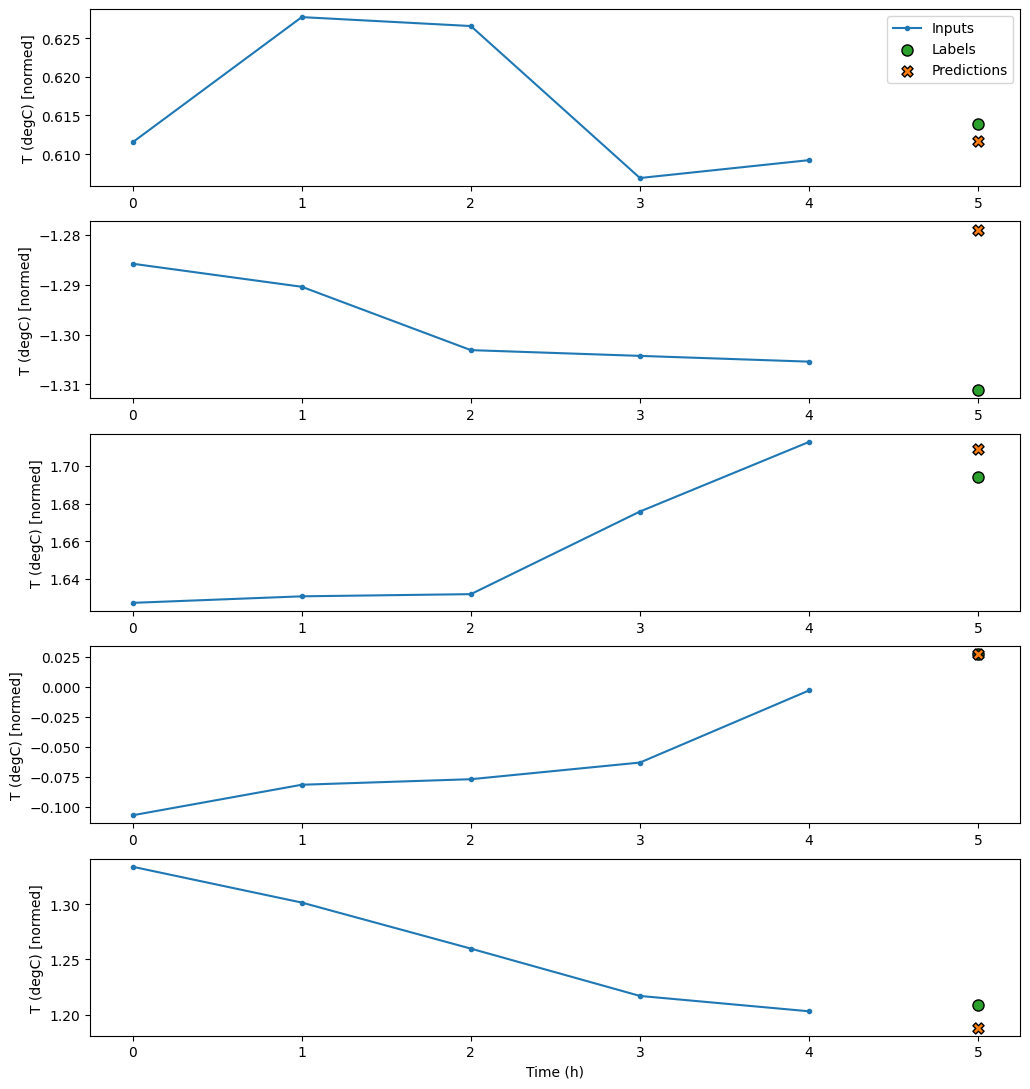

In [696]:
window.plot(ff_model, max_subplots=5)

### Plot on test data

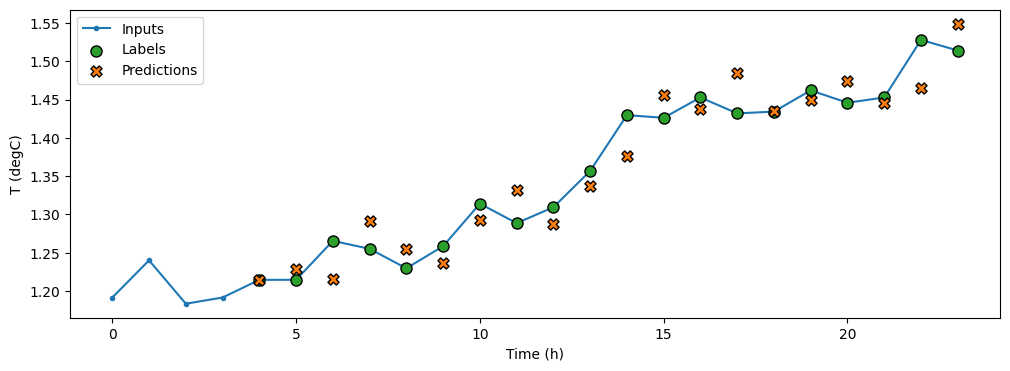

In [473]:
window.plot_test(ff_model)

## LSTM

In [1456]:
def create_lstm(output_dim=1):
	model = models.Sequential()

	# Shape [samples, time steps, features]
	model.add(layers.LSTM(32, return_sequences=True))
	model.add(layers.LSTM(2))

	model.add(layers.Dense(output_dim))

	model.add(layers.Reshape([output_dim, -1]))

	return model

In [1488]:
lstm_model = create_lstm()

In [1489]:
lstm_model.build((None, input_shapes[1], input_shapes[2]))

In [1490]:
lstm_model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 5, 32)             6656      
                                                                 
 lstm_74 (LSTM)              (None, 2)                 280       
                                                                 
 dense_459 (Dense)           (None, 1)                 3         
                                                                 
 reshape_115 (Reshape)       (None, 1, 1)              0         
                                                                 
Total params: 6,939
Trainable params: 6,939
Non-trainable params: 0
_________________________________________________________________


In [1491]:
# Run on CPU, faster here
with tf.device('/CPU:0'):
	lstm_history = compile_and_fit(lstm_model, window, patience=5)

save_model(lstm_model, "lstm_model")

Epoch 1/1000


2022-11-20 18:46:33.651106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9191/9200 [============================>.] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0341

2022-11-20 18:47:22.107558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9200/9200 [==============================] - 55s 6ms/step - loss: 0.0060 - mean_absolute_error: 0.0341 - val_loss: 8.1070e-04 - val_mean_absolute_error: 0.0196
Epoch 2/1000
9200/9200 [==============================] - 51s 5ms/step - loss: 7.1977e-04 - mean_absolute_error: 0.0188 - val_loss: 7.9625e-04 - val_mean_absolute_error: 0.0209
Epoch 3/1000
9200/9200 [==============================] - 52s 6ms/step - loss: 6.6239e-04 - mean_absolute_error: 0.0178 - val_loss: 6.3982e-04 - val_mean_absolute_error: 0.0176
Epoch 4/1000
9200/9200 [==============================] - 51s 6ms/step - loss: 6.3814e-04 - mean_absolute_error: 0.0174 - val_loss: 5.6766e-04 - val_mean_absolute_error: 0.0161
Epoch 5/1000
9200/9200 [==============================] - 52s 6ms/step - loss: 6.2241e-04 - mean_absolute_error: 0.0171 - val_loss: 5.6449e-04 - val_mean_absolute_error: 0.0159
Epoch 6/1000
9200/9200 [==============================] - 49s 5ms/step - loss: 6.0810e-04 - mean_absolute_error: 0.0168 - val_loss: 

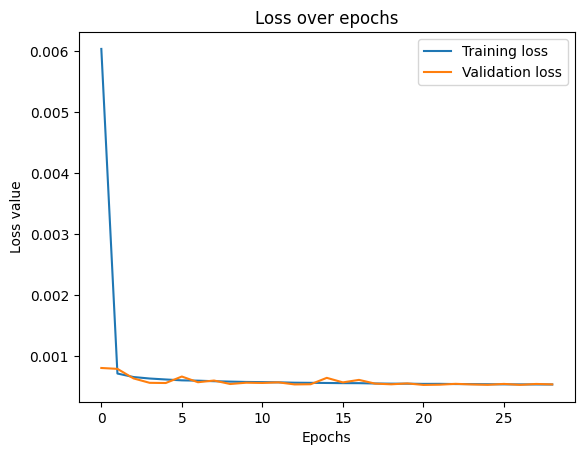

In [1492]:
plot_res(lstm_history, 0)

In [1628]:
validation_perf["lstm"] = lstm_model.evaluate(window.val)

2629/2629 [==============================] - 27s 10ms/step - loss: 5.4212e-04 - mean_absolute_error: 0.0153


In [1629]:
performance["lstm"] = evaluate_model(lstm_model, window)

1315/1315 [==============================] - 12s 9ms/step - loss: 6.1048e-04 - mean_absolute_error: 0.0168
Total loss = [0.0006104842177592218, 0.016763756051659584]


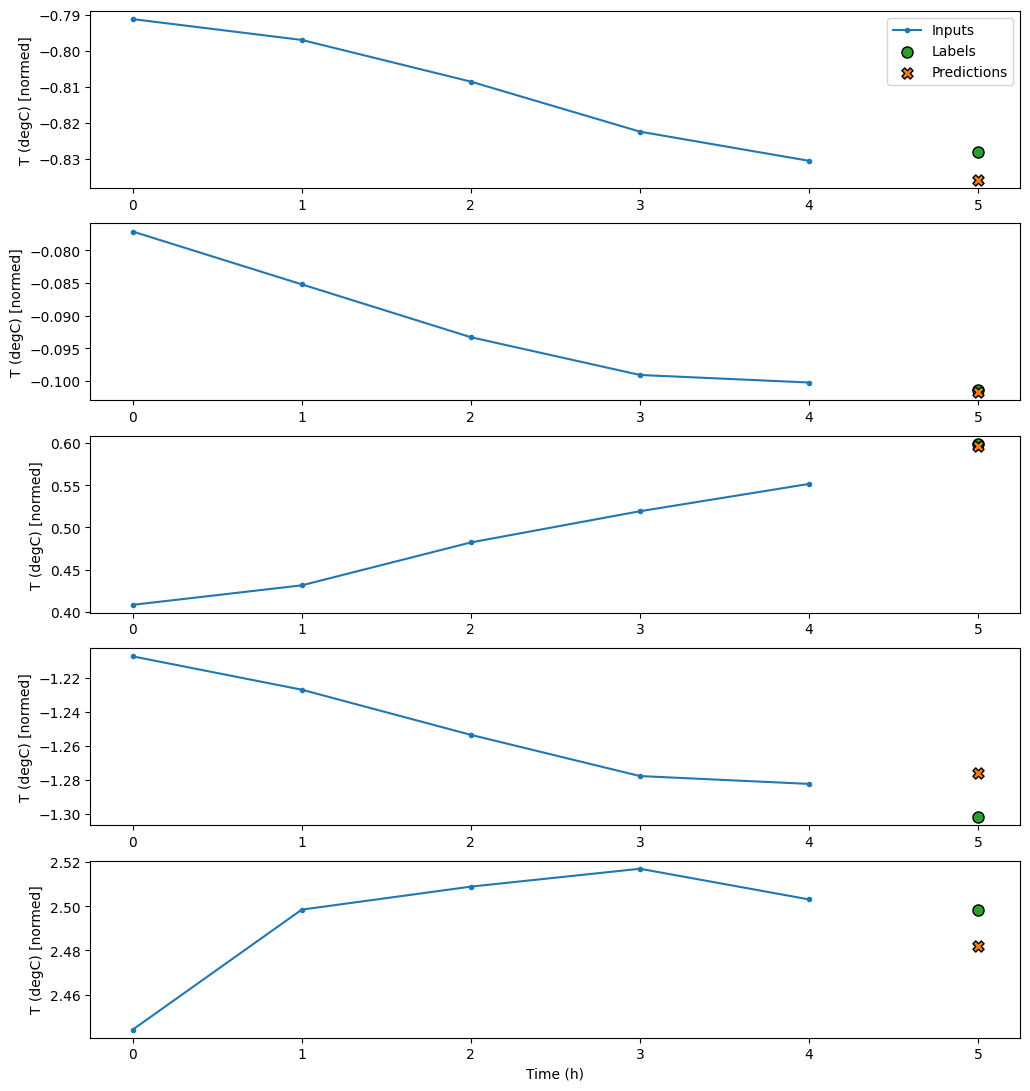

In [1495]:
window.plot(lstm_model, max_subplots=5)

### Plot on test data

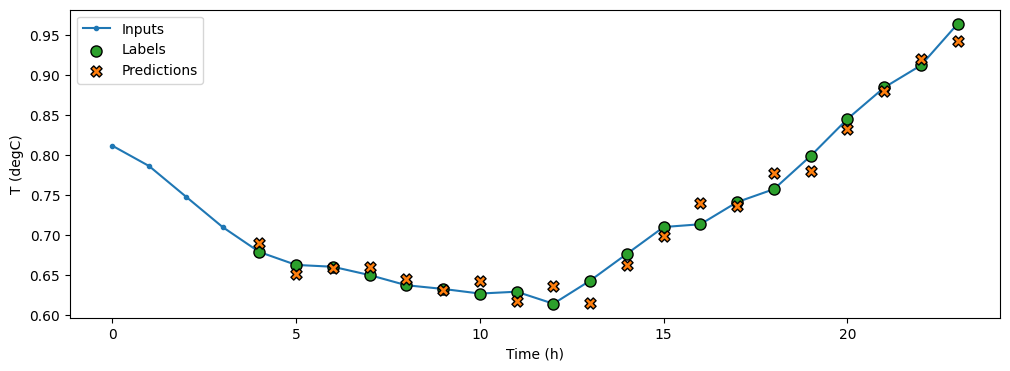

In [1496]:
window.plot_test(lstm_model)

## Transformer

In [1532]:
class FeedForward(layers.Layer):
	def __init__(self, units, activation="relu", **kwargs):
		self.units = units
		self.activation = activation
		
		self.dense = layers.Dense(units, activation=activation)
		self.norm= layers.LayerNormalization()
		self.add = layers.Add()

		super(FeedForward, self).__init__(**kwargs)

	def get_config(self):
		config = super(FeedForward, self).get_config()
		config.update({"activation": self.activation})
		config.update({"units": self.units})
		
		return config


	@tf.function
	def call(self, x):
		y = self.dense(x)
		y = self.add([x, y])
		return self.norm(y)

In [1533]:
class BaseAttention(layers.Layer):
	def __init__(self, **kwargs):
		super().__init__()
		self.multi_head_attention = layers.MultiHeadAttention(**kwargs)
		self.add = layers.Add()
		self.norm = layers.LayerNormalization()

In [1534]:
class MultiHeadAttention(BaseAttention):
	@tf.function
	def call(self, x, context=None, masked=False):
		y = self.multi_head_attention(
			query = x,
			key = context if context != None else x,
			value = context if context != None else x,
			use_causal_mask = masked
		)
		y = self.add([y, x])
		y = self.norm(y)
		return y

In [1554]:
class TransformerEncoderBlock(layers.Layer):
	def __init__(self, num_heads, key_dim, inp_shape, dense_activation="relu", **kwargs):
		self.inp_shape = inp_shape
		self.num_heads = num_heads
		self.key_dim = key_dim
		self.dense_activation = dense_activation

		self.feed_fw = FeedForward(inp_shape[2], activation=dense_activation)
		self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

		super(TransformerEncoderBlock, self).__init__(**kwargs)
		
	def get_config(self):
		config = super(TransformerEncoderBlock, self).get_config()		
		config.update({"inp_shape": self.inp_shape})	
		config.update({"num_heads": self.num_heads})	
		config.update({"key_dim": self.key_dim})	
		config.update({"dense_activation": self.dense_activation})	
		return config


	@tf.function
	def call(self, x):
		res = self.attention(x)
		return self.feed_fw(res)


In [1555]:
class TransformerDecoderBlock(layers.Layer):
	def __init__(self, num_heads, key_dim, inp_shape, dense_activation="relu", **kwargs):
		self.inp_shape = inp_shape
		self.context = None

		self.num_heads = num_heads
		self.key_dim = key_dim
		self.dense_activation = dense_activation

		self.feed_fw = FeedForward(inp_shape[2], activation=dense_activation)
		self.masked_attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

		self.cross_attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

		super(TransformerDecoderBlock, self).__init__(**kwargs)

	def get_config(self):
		config = super(TransformerDecoderBlock, self).get_config()		
		config.update({"inp_shape": self.inp_shape})	
		config.update({"context": self.context})	
		config.update({"num_heads": self.num_heads})	
		config.update({"key_dim": self.key_dim})	
		config.update({"dense_activation": self.dense_activation})	
		return config


	@tf.function
	def call(self, x, context):
		y = self.masked_attention(x, masked=True)
		y = self.cross_attention(y, context=context)

		return self.feed_fw(y)


In [1575]:
class TransformerEncoder(layers.Layer):
	def __init__(self, num_layers, num_heads, key_dim, inp_shape, dense_activation="relu", **kwargs):

		self.num_layers = num_layers
		self.num_heads = num_heads
		self.key_dim = key_dim
		self.inp_shape = inp_shape
		self.dense_activation = dense_activation

		self.layers = [
			TransformerEncoderBlock(num_heads, key_dim, inp_shape, dense_activation)
			for _ in range(num_layers)
		]
		super(TransformerEncoder, self).__init__(**kwargs)

	def get_config(self):
		config = super(TransformerEncoder, self).get_config()		
		config.update({"num_layers": self.num_layers})	

		config.update({"inp_shape": self.inp_shape})	
		config.update({"num_heads": self.num_heads})	
		config.update({"key_dim": self.key_dim})	
		config.update({"dense_activation": self.dense_activation})
		return config

	@tf.function
	def call(self, x):
		y = x
		for layer in self.layers:
			y = layer(y)

		return y

In [1582]:
class TransformerDecoder(layers.Layer):
	def __init__(self, num_layers, num_heads, key_dim, inp_shape, dense_activation="relu", **kwargs):

		self.num_layers = num_layers
		self.num_heads = num_heads
		self.key_dim = key_dim
		self.inp_shape = inp_shape
		self.dense_activation = dense_activation

		self.layers = [
			TransformerDecoderBlock(num_heads, key_dim, inp_shape, dense_activation)
			for _ in range(num_layers)
		]
		self.context = None

		super(TransformerDecoder, self).__init__(**kwargs)

	def get_config(self):
		config = super(TransformerDecoder, self).get_config()		
		config.update({"num_layers": self.num_layers})	

		config.update({"inp_shape": self.inp_shape})	
		config.update({"num_heads": self.num_heads})	
		config.update({"key_dim": self.key_dim})	
		config.update({"dense_activation": self.dense_activation})
		return config

	@tf.function
	def call(self, x, context=None):
		y = x
		for layer in self.layers:
			y = layer(y, context)

		return y

In [1564]:
class Transformer(layers.Layer):
	def __init__(self, encoder: TransformerEncoder, decoder: TransformerDecoder, **kwargs):
		self.encoder = encoder
		self.decoder = decoder

		super(Transformer, self).__init__(**kwargs)

	def get_config(self):
		config = super(Transformer, self).get_config()		
		config.update({"encoder": self.encoder})	
		config.update({"decoder": self.decoder})	
		return config

	@tf.function
	def call(self, x):
		y = self.encoder(x)
		y = self.decoder(y, x)
		return y


In [1590]:
def create_transformer(input_shape, output_dim=1):
	input_tensor = layers.Input(shape=input_shape)

	encoder = TransformerEncoder(1, 3, 4, input_tensor.shape)
	decoder = TransformerDecoder(1, 3, 4, input_tensor.shape)

	x = Transformer(encoder, decoder)(input_tensor)

	y = layers.Flatten()(x)
	y = layers.Dense(32, activation="relu")(y)

	y = layers.Dense(output_dim)(y)

	output_tensor = layers.Reshape([output_dim, -1])(y)

	return models.Model(input_tensor, output_tensor)

In [1591]:
def save_transformer_model(model: models.Model, name: str):
	model.save(f"../../resources/weather_forecasting/{name}.h5")	
	
def load_transformer_model(name: str):
	models.load_model(f"../../resources/weather_forecasting/{name}.h5", custom_objects={
		"Transformer": Transformer,
		'TransformerEncoderBlock': TransformerEncoderBlock, 
		"TransformerDecoderBlock": TransformerDecoderBlock,
		"TransformerEncoder": TransformerEncoder,
		"TransformerDecoder": TransformerDecoder
		})

In [1592]:
transformer_model = create_transformer((input_shapes[1], input_shapes[2]), output_dim=label_shapes[1])
transformer_model.summary()

Model: "model_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_219 (InputLayer)      [(None, 5, 19)]           0         
                                                                 
 transformer_9 (Transformer)  (None, 5, 19)            3851      
                                                                 
 flatten_102 (Flatten)       (None, 95)                0         
                                                                 
 dense_505 (Dense)           (None, 32)                3072      
                                                                 
 dense_506 (Dense)           (None, 1)                 33        
                                                                 
 reshape_125 (Reshape)       (None, 1, 1)              0         
                                                                 
Total params: 6,956
Trainable params: 6,956
Non-trainable 

In [ ]:
with tf.device('CPU'):
	transformer_history = compile_and_fit(transformer_model, window, patience=5)

save_transformer_model(transformer_model, "transformer_model")

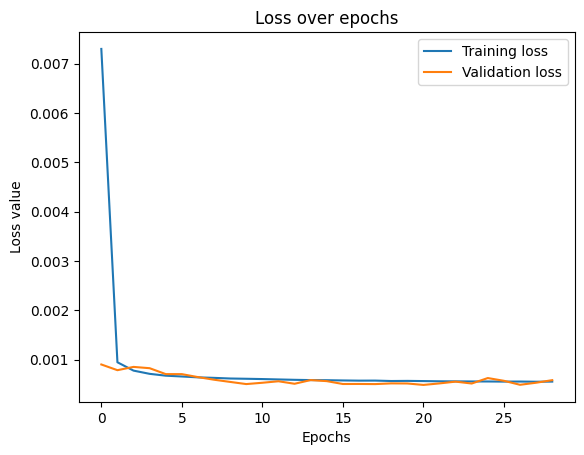

In [1594]:
plot_res(transformer_history, 0)

In [1630]:
validation_perf["transformer"] = transformer_model.evaluate(window.val)

2022-11-20 22:24:44.583708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2629/2629 [==============================] - 53s 20ms/step - loss: 4.9730e-04 - mean_absolute_error: 0.0145


In [1631]:
performance["transformer"] = evaluate_model(transformer_model, window)

1315/1315 [==============================] - 26s 20ms/step - loss: 5.4007e-04 - mean_absolute_error: 0.0155
Total loss = [0.0005400656373240054, 0.015513748861849308]


2022-11-20 20:35:23.982172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


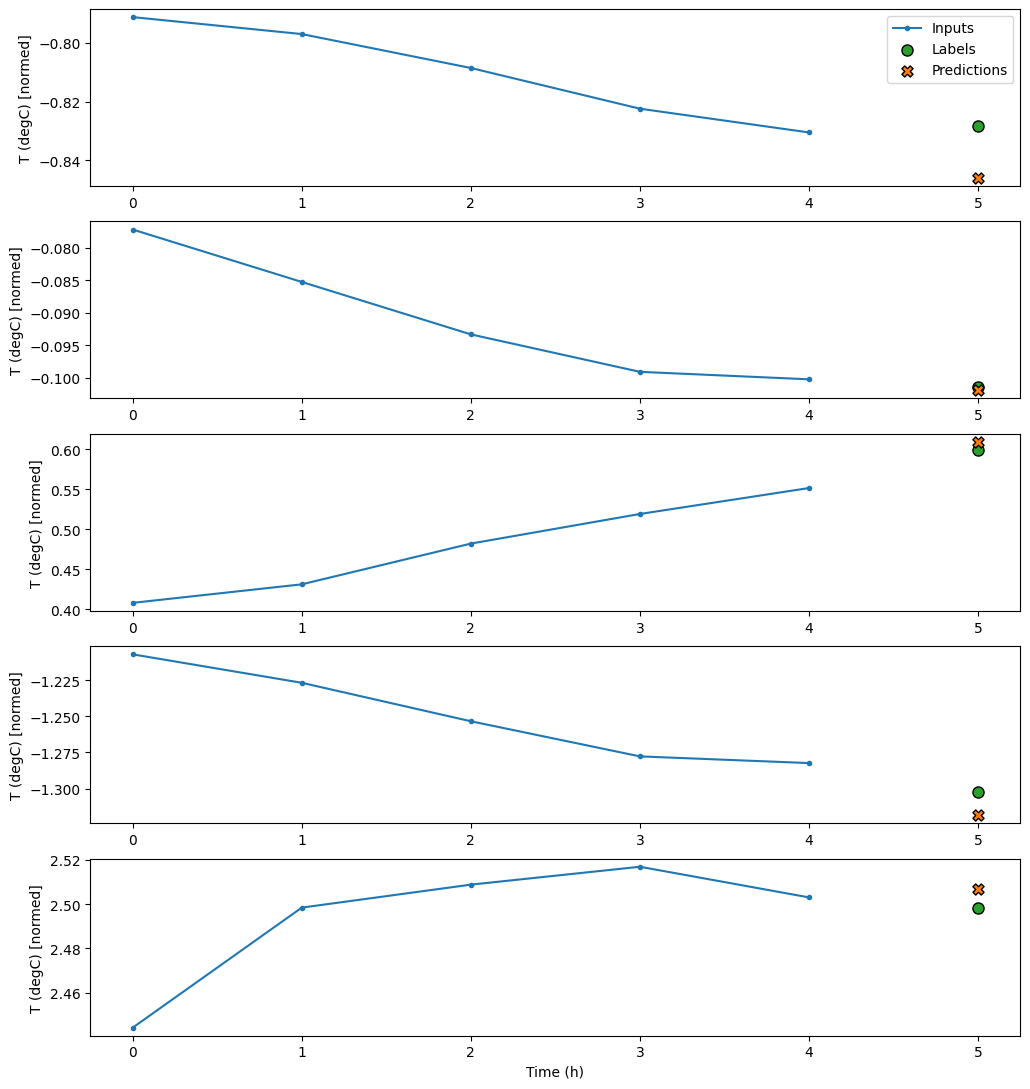

In [1597]:
window.plot(transformer_model, max_subplots=5)

### Plot on test data

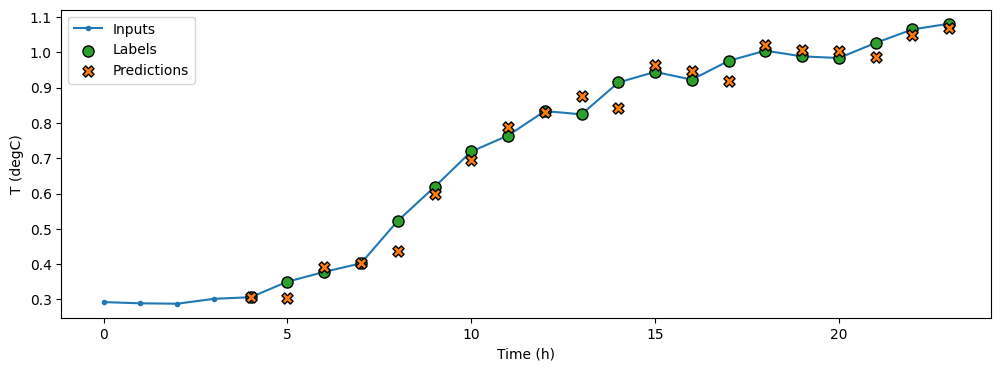

In [1599]:
window.plot_test(transformer_model)

# Multi outputs (same models)

In [1602]:
in_dim = 15
out_dim = 5

# Given a 15 hours input, predict the next 5 hours (Temperature in °C)
window_multi = WindowGenerator(in_dim, out_dim, out_dim, train_data, validation_data, test_data, label_columns=["T (degC)"])

input_shapes = window_multi.shapes()[0]
label_shapes = window_multi.shapes()[1]

In [1603]:
input_shapes

TensorShape([32, 15, 19])

In [1604]:
label_shapes

TensorShape([32, 5, 1])

## Feed Forward

In [1605]:
ff_model_multi = create_feed_forward(label_shapes[1])

In [1606]:
ff_history_multi = compile_and_fit(ff_model_multi, window_multi, patience=5)
save_model(ff_model_multi, "ff_model_multi")

Epoch 1/1000


2022-11-20 20:36:47.933225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9199/9199 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0566

2022-11-20 20:37:47.452920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9199/9199 [==============================] - 69s 7ms/step - loss: 0.0083 - mean_absolute_error: 0.0566 - val_loss: 0.0037 - val_mean_absolute_error: 0.0412
Epoch 2/1000
9199/9199 [==============================] - 66s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0433 - val_loss: 0.0035 - val_mean_absolute_error: 0.0391
Epoch 3/1000
9199/9199 [==============================] - 66s 7ms/step - loss: 0.0038 - mean_absolute_error: 0.0416 - val_loss: 0.0035 - val_mean_absolute_error: 0.0395
Epoch 4/1000
9199/9199 [==============================] - 66s 7ms/step - loss: 0.0036 - mean_absolute_error: 0.0407 - val_loss: 0.0036 - val_mean_absolute_error: 0.0409
Epoch 5/1000
9199/9199 [==============================] - 66s 7ms/step - loss: 0.0036 - mean_absolute_error: 0.0400 - val_loss: 0.0038 - val_mean_absolute_error: 0.0428
Epoch 6/1000
9199/9199 [==============================] - 72s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0394 - val_loss: 0.0032 - val_mean_absolute_error: 0.0371

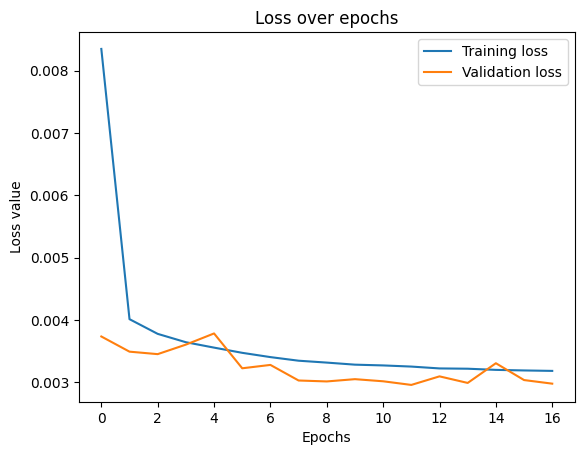

In [1607]:
plot_res(ff_history_multi, 0)

In [1632]:
validation_perf_multi["ff"] = ff_model_multi.evaluate(window_multi.val)

2628/2628 [==============================] - 13s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0351


In [1633]:
performance_multi["ff"] = evaluate_model(ff_model_multi, window_multi)

1314/1314 [==============================] - 6s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0361
Total loss = [0.003044005949050188, 0.03610309213399887]


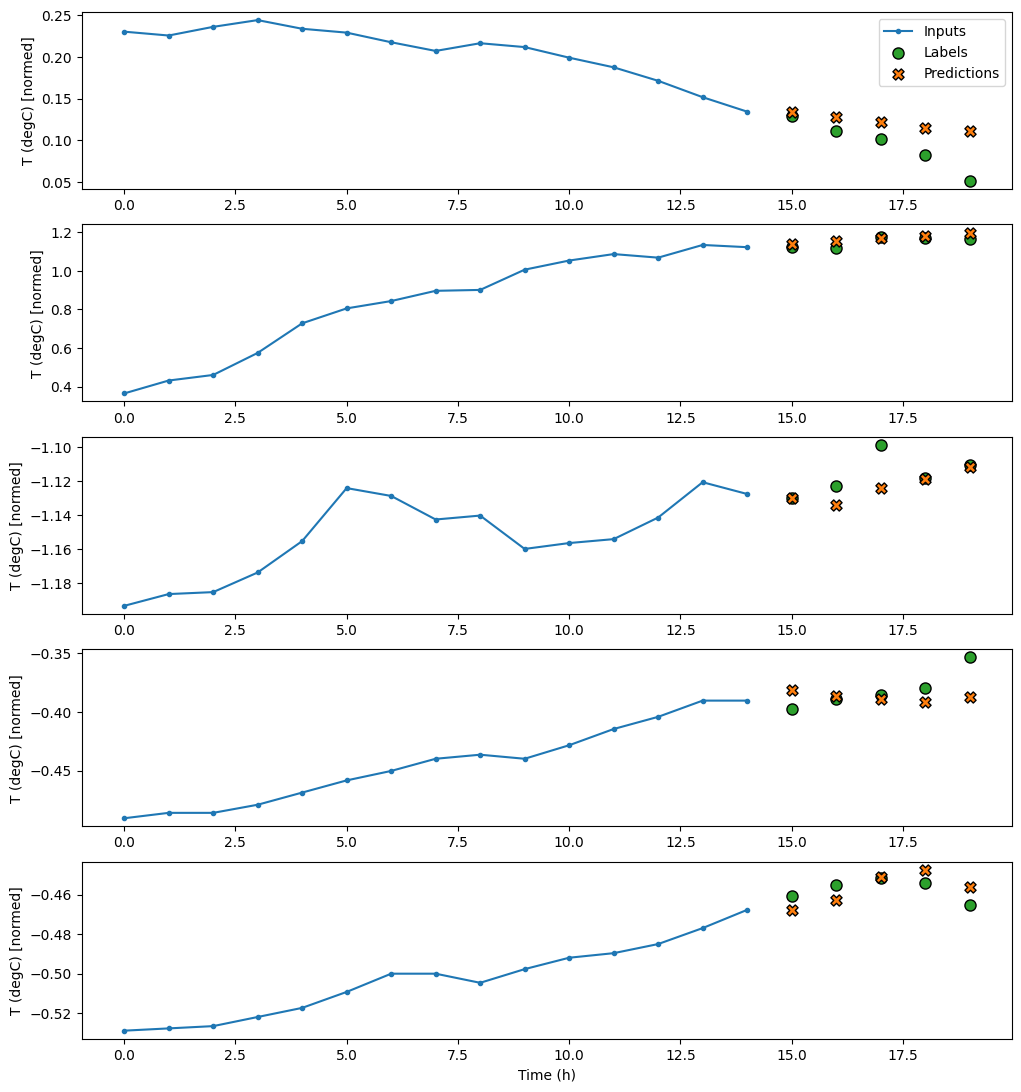

In [1610]:
window_multi.plot(ff_model_multi, max_subplots=5)

## LSTM

In [1611]:
lstm_model_multi = create_lstm(label_shapes[1])

In [1612]:
# Run on CPU, faster here
with tf.device('/CPU:0'):
	lstm_history_multi = compile_and_fit(lstm_model_multi, window_multi, patience=5)

save_model(lstm_model_multi, "lstm_model_multi")

Epoch 1/1000


2022-11-20 20:56:03.386829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9189/9199 [============================>.] - ETA: 0s - loss: 0.0520 - mean_absolute_error: 0.0922

2022-11-20 20:56:45.500757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9199/9199 [==============================] - 49s 5ms/step - loss: 0.0520 - mean_absolute_error: 0.0922 - val_loss: 0.0036 - val_mean_absolute_error: 0.0393
Epoch 2/1000
9199/9199 [==============================] - 45s 5ms/step - loss: 0.0036 - mean_absolute_error: 0.0400 - val_loss: 0.0032 - val_mean_absolute_error: 0.0363
Epoch 3/1000
9199/9199 [==============================] - 43s 5ms/step - loss: 0.0033 - mean_absolute_error: 0.0374 - val_loss: 0.0030 - val_mean_absolute_error: 0.0353
Epoch 4/1000
9199/9199 [==============================] - 43s 5ms/step - loss: 0.0032 - mean_absolute_error: 0.0365 - val_loss: 0.0030 - val_mean_absolute_error: 0.0349
Epoch 5/1000
9199/9199 [==============================] - 46s 5ms/step - loss: 0.0031 - mean_absolute_error: 0.0362 - val_loss: 0.0031 - val_mean_absolute_error: 0.0369
Epoch 6/1000
9199/9199 [==============================] - 45s 5ms/step - loss: 0.0031 - mean_absolute_error: 0.0359 - val_loss: 0.0032 - val_mean_absolute_error: 0.0380

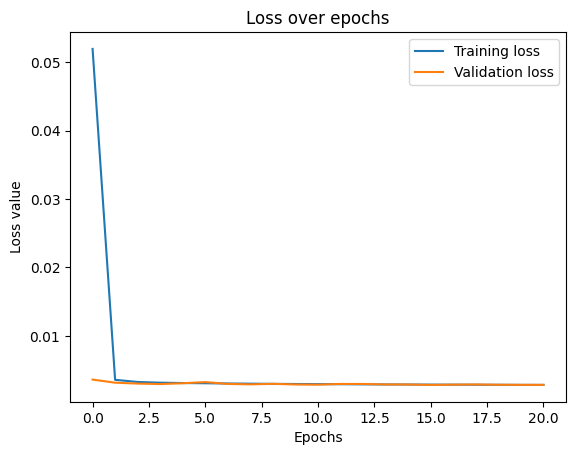

In [1613]:
plot_res(lstm_history_multi, 0)

In [1634]:
validation_perf_multi["lstm"] = lstm_model_multi.evaluate(window_multi.val)

2628/2628 [==============================] - 33s 13ms/step - loss: 0.0028 - mean_absolute_error: 0.0336


In [1635]:
performance_multi["lstm"] = evaluate_model(lstm_model_multi, window_multi)

1314/1314 [==============================] - 17s 13ms/step - loss: 0.0029 - mean_absolute_error: 0.0348
Total loss = [0.0028848147485405207, 0.0347813256084919]


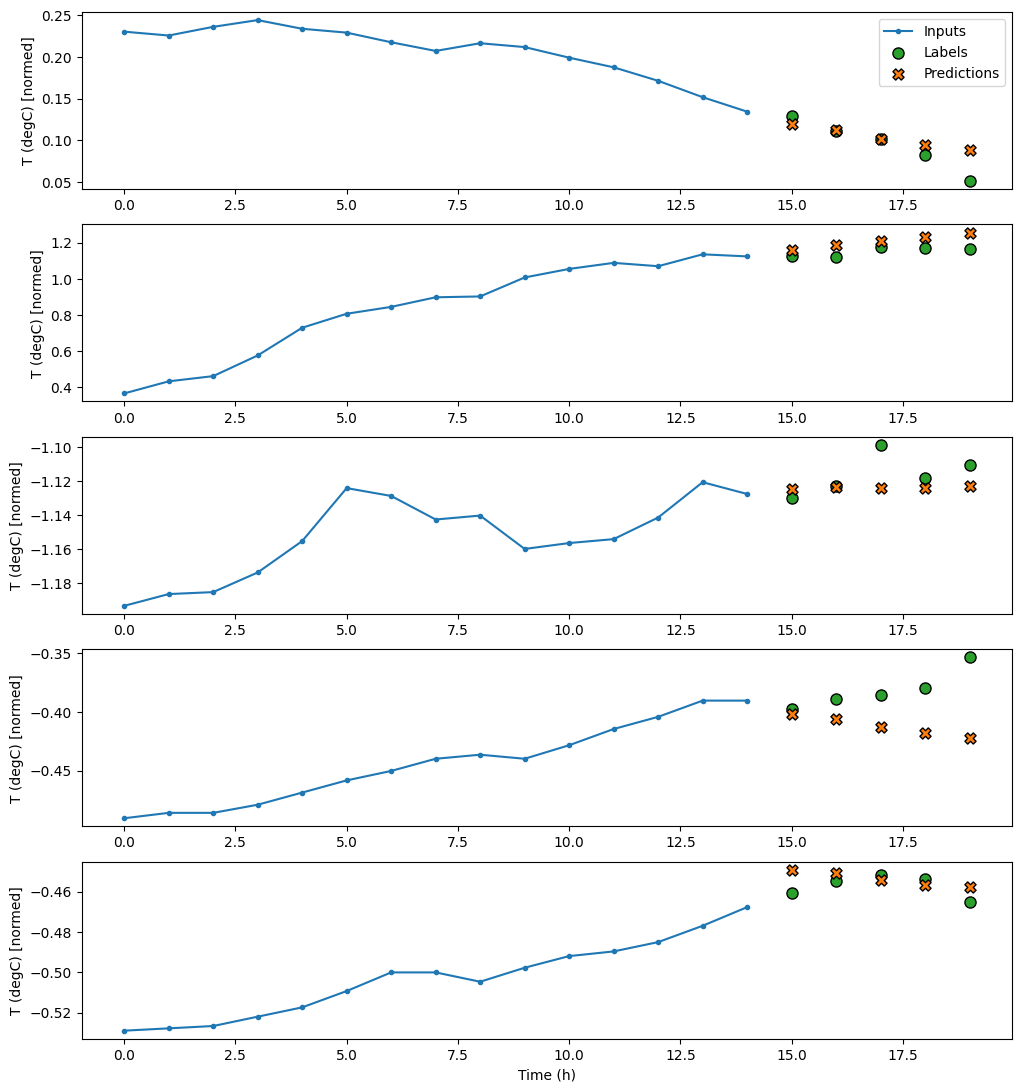

In [1616]:
window_multi.plot(lstm_model_multi, max_subplots=5)

## Transformer

In [1617]:
transformer_model_multi = create_transformer((input_shapes[1], input_shapes[2]), output_dim=label_shapes[1])

In [1618]:
with tf.device('CPU'):
	transformer_history_multi = compile_and_fit(transformer_model_multi, window_multi, patience=5)

save_transformer_model(transformer_model_multi, "transformer_model_multi")

Epoch 1/1000


2022-11-20 21:12:43.737084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9198/9199 [============================>.] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0632

2022-11-20 21:15:04.700951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9199/9199 [==============================] - 154s 16ms/step - loss: 0.0116 - mean_absolute_error: 0.0632 - val_loss: 0.0042 - val_mean_absolute_error: 0.0453
Epoch 2/1000
9199/9199 [==============================] - 141s 15ms/step - loss: 0.0038 - mean_absolute_error: 0.0418 - val_loss: 0.0043 - val_mean_absolute_error: 0.0479
Epoch 3/1000
9199/9199 [==============================] - 140s 15ms/step - loss: 0.0035 - mean_absolute_error: 0.0396 - val_loss: 0.0033 - val_mean_absolute_error: 0.0377
Epoch 4/1000
9199/9199 [==============================] - 138s 15ms/step - loss: 0.0034 - mean_absolute_error: 0.0386 - val_loss: 0.0033 - val_mean_absolute_error: 0.0379
Epoch 5/1000
9199/9199 [==============================] - 141s 15ms/step - loss: 0.0033 - mean_absolute_error: 0.0379 - val_loss: 0.0032 - val_mean_absolute_error: 0.0370
Epoch 6/1000
9199/9199 [==============================] - 136s 15ms/step - loss: 0.0032 - mean_absolute_error: 0.0372 - val_loss: 0.0030 - val_mean_absolute_e

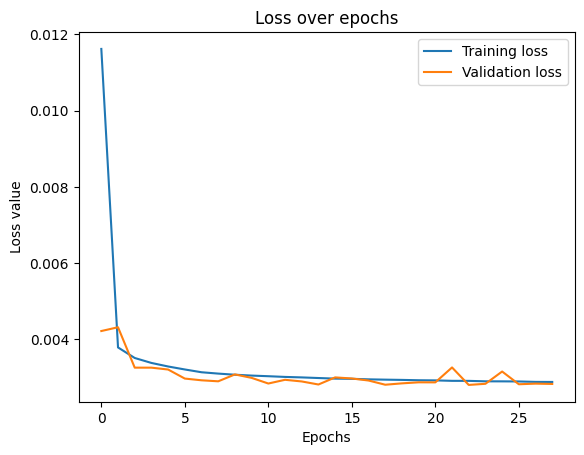

In [1619]:
plot_res(transformer_history_multi, 0)

In [1636]:
validation_perf_multi["transformer"] = transformer_model_multi.evaluate(window_multi.val)

2628/2628 [==============================] - 52s 20ms/step - loss: 0.0028 - mean_absolute_error: 0.0331


In [1643]:
performance_multi["transformer"] = evaluate_model(transformer_model_multi, window_multi)

1314/1314 [==============================] - 26s 19ms/step - loss: 0.0029 - mean_absolute_error: 0.0346
Total loss = [0.002888784511014819, 0.0345788411796093]


2022-11-20 22:20:14.516731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


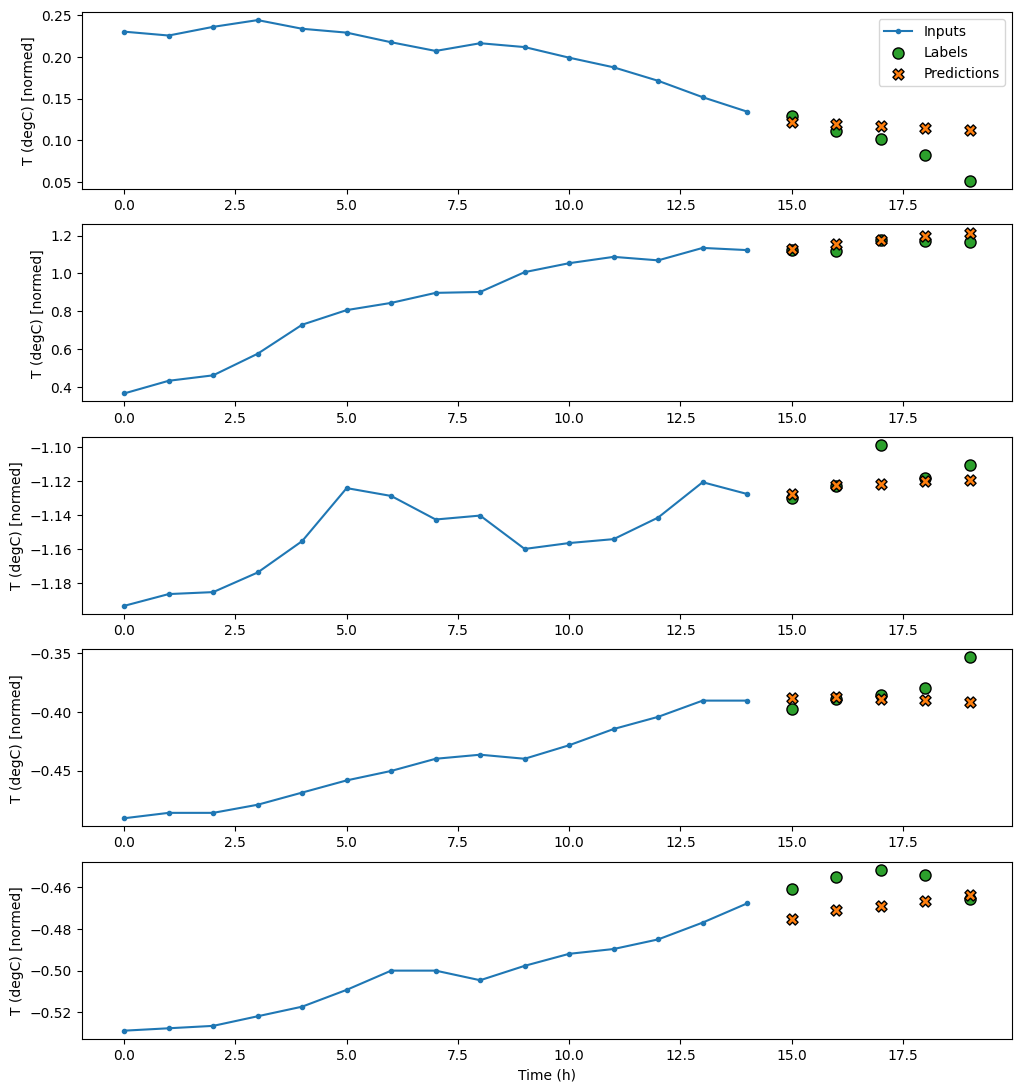

In [1622]:
window_multi.plot(transformer_model_multi, max_subplots=5)

# Performances

### Single Output

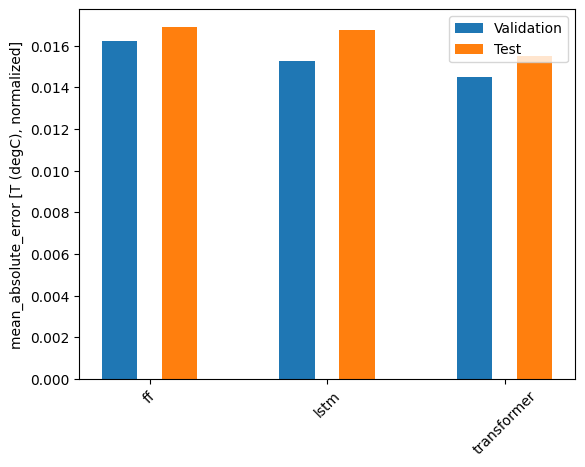

In [1669]:
performances = np.arange(len(performance))
width = 0.2
metric_name = "mean_absolute_error"
metric_index = lstm_model.metrics_names.index("mean_absolute_error")
val_mae = [v[metric_index] for v in validation_perf.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel("mean_absolute_error [T (degC), normalized]")
plt.bar(performances - 0.17, val_mae, width, label="Validation")
plt.bar(performances + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=performances, labels=performance.keys(), rotation=45)
_ = plt.legend()

In [1681]:
for key in performance.keys():
	print(f"\n--------------------- {key.upper()} ---------------------\n")
	print(f"Validation: {round(validation_perf[key][1], 5)}")
	print(f"Test: {round(performance[key][1], 5)}")


--------------------- FF ---------------------

Validation: 0.01621
Test: 0.0169

--------------------- LSTM ---------------------

Validation: 0.01527
Test: 0.01676

--------------------- TRANSFORMER ---------------------

Validation: 0.01449
Test: 0.01551


### Multiple Outputs

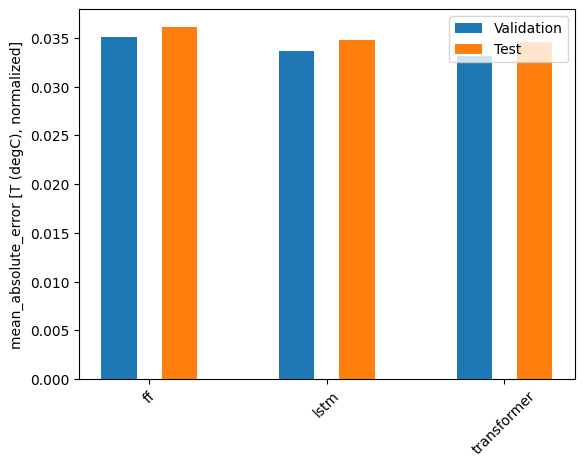

In [1668]:
performances = np.arange(len(performance_multi))
width = 0.2
metric_name = "mean_absolute_error"
metric_index = lstm_model.metrics_names.index("mean_absolute_error")
val_mae = [v[metric_index] for v in validation_perf_multi.values()]
test_mae = [v[metric_index] for v in performance_multi.values()]

plt.ylabel("mean_absolute_error [T (degC), normalized]")
plt.bar(performances - 0.17, val_mae, width, label="Validation")
plt.bar(performances + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=performances, labels=performance.keys(), rotation=45)
_ = plt.legend()

In [1680]:
for key in performance_multi.keys():
	print(f"\n--------------------- {key.upper()} ---------------------\n")
	print(f"Validation: {round(validation_perf_multi[key][1], 5)}")
	print(f"Test: {round(performance_multi[key][1], 5)}")


--------------------- FF ---------------------

Validation: 0.03508
Test: 0.0361

--------------------- LSTM ---------------------

Validation: 0.03364
Test: 0.03478

--------------------- TRANSFORMER ---------------------

Validation: 0.03313
Test: 0.03458
